Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
x_data의 shape :  (20, 150, 150, 3)
t_data의 shape :  (20,)


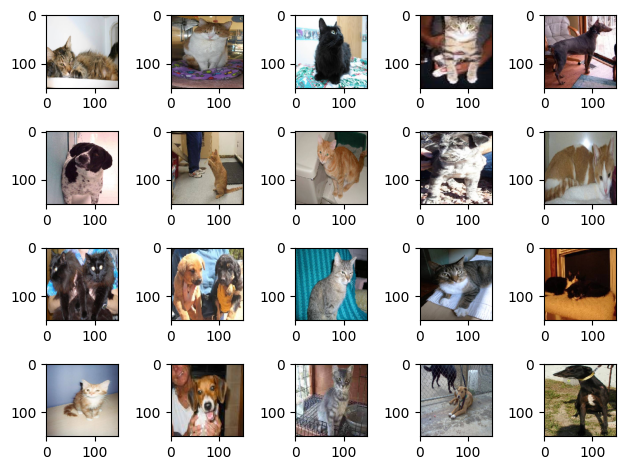

In [ ]:
# ImageDataGenerator에 대해서 알아보아요!

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

train_dir = '/content/drive/MyDrive/빅데이터 과정 폴더/data/cat_dog_small/train'
validation_dir = '/content/drive/MyDrive/빅데이터 과정 폴더/data/cat_dog_small/validation'

# ImageDataGenerator를 생성(객체 생성)
train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

# ImageDataGenerator 객체 세부 설정
train_generator = train_datagen.flow_from_directory(
    train_dir, # target directory
    classes=['cats', 'dogs'], # label(target) 지정, list의 순서대로 지정.
                              # 만약 생략되면 폴더 순서(오름차순)로 지정되요
    target_size=(150,150), # image resize
    batch_size=20,   # 한번에 20개의 이미지를 가져와요!
                     # label에 상관없이 이미지를 가져와요!
    class_mode='binary'   # 이진분류이기 때문에 binary
                          # 만약 다중분류이면 categorical
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    classes=['cats', 'dogs'],
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

for x_data, t_data in train_generator:
    print('x_data의 shape : ', x_data.shape) # (20,150,150,3)
    print('t_data의 shape : ', t_data.shape) # (20,)
    break

fig = plt.figure()
axs = []   # subplot에 대한 list (20개의 subplot을 저장하려는 용도)

for i in range(20):
    axs.append(fig.add_subplot(4,5,i+1))

for x_data, t_data in train_generator:
    # x_data => (20,150,150,3)
    for idx, img_data in enumerate(x_data):
        axs[idx].imshow(img_data)
    break

plt.tight_layout()
plt.show()

In [ ]:
# 아하.. ImageDataGenerator는 저렇게 사용하는거군요!
# 이제 CNN모델을 만들고 ImageDataGenerator를 이용해서 학습을 진행해 보아요!

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# ImageDataGenerator 생성
train_dir = '/content/drive/MyDrive/빅데이터 과정 폴더/data/cat_dog_small/train'
validation_dir = '/content/drive/MyDrive/빅데이터 과정 폴더/data/cat_dog_small/validation'

# ImageDataGenerator를 생성(객체 생성)
train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

# ImageDataGenerator 객체 세부 설정
train_generator = train_datagen.flow_from_directory(
    train_dir, # target directory
    classes=['cats', 'dogs'], # label(target) 지정, list의 순서대로 지정.
                              # 만약 생략되면 폴더 순서(오름차순)로 지정되요
    target_size=(150,150), # image resize
    batch_size=20,   # 한번에 20개의 이미지를 가져와요!
                     # label에 상관없이 이미지를 가져와요!
    class_mode='binary'   # 이진분류이기 때문에 binary
                          # 만약 다중분류이면 categorical
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    classes=['cats', 'dogs'],
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
# Model 구현
model = Sequential()

model.add(Conv2D(filters=32,
                 kernel_size=(3,3),
                 strides=(1,1),
                 activation='relu',
                 input_shape=(150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64,
                 kernel_size=(3,3),
                 strides=(1,1),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=128,
                 kernel_size=(3,3),
                 strides=(1,1),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=256,
                 kernel_size=(3,3),
                 strides=(1,1),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dropout(rate=0.5))
model.add(Dense(units=256,
                activation='relu'))
model.add(Dense(units=1,
                activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 17, 17, 128)      

In [ ]:
# model 학습 설정하고 학습을 진행
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_cp = ModelCheckpoint(filepath='cat_dog_checkpoint.ckpt',
                           save_weights_only=True,
                           save_best_only=True,
                           monitor='val_loss',
                           verbose=1)

model_es = EarlyStopping(monitor='val_loss',
                         patience=5,
                         verbose=1,
                         restore_best_weights=True)

history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=100,
                    verbose=1,
                    validation_data=validation_generator,
                    validation_steps=50,
                    callbacks=[model_cp, model_es])

model.save('./cat_dog_small_cnn_model.h5')

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 0.6907 - accuracy: 0.5330
Epoch 1: val_loss improved from inf to 0.68157, saving model to cat_dog_checkpoint.ckpt
100/100 [==============================] - 321s 3s/step - loss: 0.6907 - accuracy: 0.5330 - val_loss: 0.6816 - val_accuracy: 0.5050
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 0.6604 - accuracy: 0.5995
Epoch 2: val_loss improved from 0.68157 to 0.64497, saving model to cat_dog_checkpoint.ckpt
100/100 [==============================] - 132s 1s/step - loss: 0.6604 - accuracy: 0.5995 - val_loss: 0.6450 - val_accuracy: 0.6220
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 0.6270 - accuracy: 0.6625
Epoch 3: val_loss improved from 0.64497 to 0.63709, saving model to cat_dog_checkpoint.ckpt
100/100 [==============================] - 130s 1s/step - loss: 0.6270 - accuracy: 0.6625 - val_loss: 0.6371 - val_accuracy: 0.6340
Epoch 4/100
100/100 [====================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


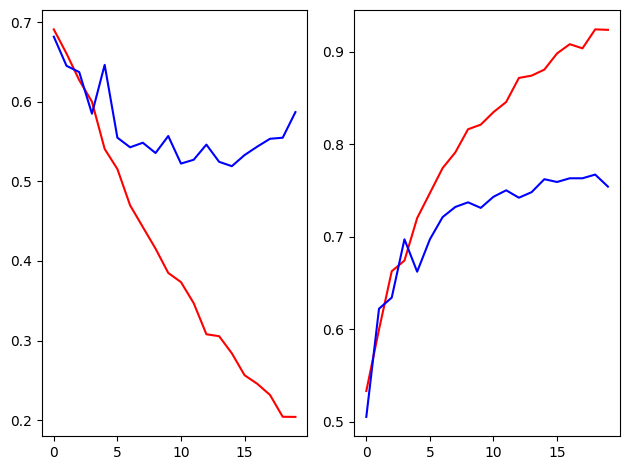

In [ ]:
# 결과 그래프를 그려보아요!

fig = plt.figure()

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.plot(history.history['loss'], color='r')
ax1.plot(history.history['val_loss'], color='b')

ax2.plot(history.history['accuracy'], color='r')
ax2.plot(history.history['val_accuracy'], color='b')

plt.tight_layout()
plt.show()

<class 'PIL.Image.Image'>
<class 'numpy.ndarray'> (150, 150, 3)
(1, 150, 150, 3)


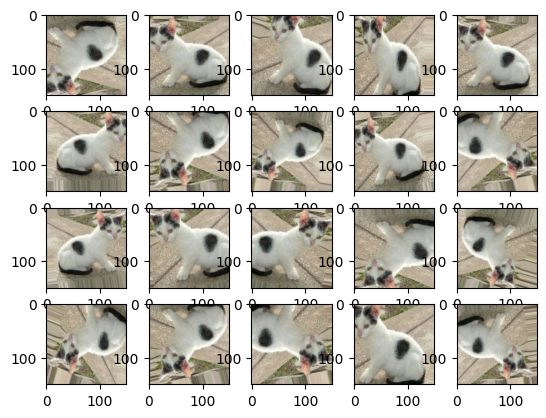

In [ ]:
# 결과를 살펴보았더니..Overfitting이 너무 심해요!
# 일단 정확도도 중요하지만 이거부터 해결해야 해요!
# 우리가 가지고 있는 ImageDataGenerator를 이용해서 증식기법을 통해
# overfitting을 해결해  보아요!

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

datagen = ImageDataGenerator(rotation_range=20,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             shear_range=0.1,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             vertical_flip=True,
                             fill_mode='nearest')

img = image.load_img('/content/drive/MyDrive/빅데이터 과정 폴더/data/cat_dog_small/train/cats/cat.3.jpg',
                    target_size=(150,150))

print(type(img))
x = image.img_to_array(img)
print(type(x),x.shape) #(150,150,3)
# 현재 이미지가 1장이에요 이 이미지에 대해서 imagedatagenerator를 이용해서 (augmentation)증식된 이미지를 뽑음
# 그런데 imagedatagenerator는 여러장의 이미지를 추출하는 거라서 기본적으로 4차원이 필요함
x =x.reshape((1,)+x.shape)
print(x.shape)

#증식된 이미지 20장 그려보기
fig = plt.figure()
axs = []

for i in range(20):
    axs.append(fig.add_subplot(4,5,i+1))

idx = 0
for batch in datagen.flow(x, batch_size=1):
    axs[idx].imshow(image.array_to_img(batch[0]))
    idx += 1
    if idx % 20 == 0:
        break;


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 0.6917 - accuracy: 0.5395
Epoch 1: val_loss improved from inf to 0.69171, saving model to cat_dog_checkpoint.ckpt
100/100 [==============================] - 154s 2s/step - loss: 0.6917 - accuracy: 0.5395 - val_loss: 0.6917 - val_accuracy: 0.5120
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 0.6860 - accuracy: 0.5570
Epoch 2: val_loss improved from 0.69171 to 0.67359, saving model to cat_dog_checkpoint.ckpt
100/100 [==============================] - 148s 1s/step - loss: 0.6860 - accuracy: 0.5570 - val_loss: 0.6736 - val_accuracy: 0.5860
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 0.6672 - accuracy: 0.6000
Epoch 3: val_loss did not improve from 0.67359
100/100 [==============================] - 145s 1s/step - loss: 0.6672 - accuracy: 0.6000 - val_loss: 0.6761 - val_accuracy: 0.5800
Ep

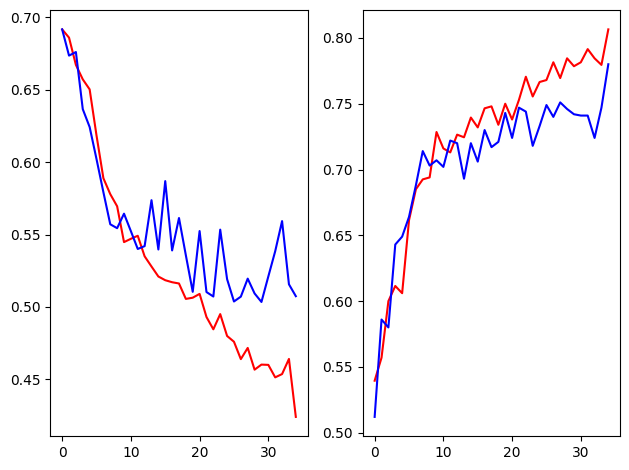

In [ ]:
# 증식이 어떤건지 알아보았으니..
# 위쪽에서 수행한 코드를 증식을 포함해서 수정해서 다시 한번
# 학습을 진행해 보아요!

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ImageDataGenerator 생성
train_dir = '/content/drive/MyDrive/빅데이터 과정 폴더/data/cat_dog_small/train'
validation_dir = '/content/drive/MyDrive/빅데이터 과정 폴더/data/cat_dog_small/validation'

# ImageDataGenerator를 생성(객체 생성)
train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1/255)

# ImageDataGenerator 객체 세부 설정
train_generator = train_datagen.flow_from_directory(
    train_dir, # target directory
    classes=['cats', 'dogs'], # label(target) 지정, list의 순서대로 지정.
                              # 만약 생략되면 폴더 순서(오름차순)로 지정되요
    target_size=(150,150), # image resize
    batch_size=20,   # 한번에 20개의 이미지를 가져와요!
                     # label에 상관없이 이미지를 가져와요!
    class_mode='binary'   # 이진분류이기 때문에 binary
                          # 만약 다중분류이면 categorical
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    classes=['cats', 'dogs'],
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

# Model 구현
model = Sequential()

model.add(Conv2D(filters=32,
                 kernel_size=(3,3),
                 strides=(1,1),
                 activation='relu',
                 input_shape=(150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64,
                 kernel_size=(3,3),
                 strides=(1,1),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=128,
                 kernel_size=(3,3),
                 strides=(1,1),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=256,
                 kernel_size=(3,3),
                 strides=(1,1),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dropout(rate=0.5))
model.add(Dense(units=256,
                activation='relu'))
model.add(Dense(units=1,
                activation='sigmoid'))

# model 학습 설정하고 학습을 진행
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_cp = ModelCheckpoint(filepath='cat_dog_checkpoint.ckpt',
                           save_weights_only=True,
                           save_best_only=True,
                           monitor='val_loss',
                           verbose=1)

model_es = EarlyStopping(monitor='val_loss',
                         patience=5,
                         verbose=1,
                         restore_best_weights=True)

history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=100,
                    verbose=1,
                    validation_data=validation_generator,
                    validation_steps=50,
                    callbacks=[model_cp, model_es])

model.save('./cat_dog_small_cnn_model.h5')

# 결과 그래프를 그려보아요!

fig = plt.figure()

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.plot(history.history['loss'], color='r')
ax1.plot(history.history['val_loss'], color='b')

ax2.plot(history.history['accuracy'], color='r')
ax2.plot(history.history['val_accuracy'], color='b')

plt.tight_layout()
plt.show()

In [ ]:
# 위의 방법(Augmentation)으로 overfitting은 많이 줄였는데
# 정확도는 많이 올라가지 않아요!
# Pretrained Network을 이용해 보아요!
# CNN의 이미지 특징을 추출하는 부분의 Filter를 활용해서
# 우리 모델을 완성해 볼꺼예요!

from tensorflow.keras.applications import VGG16

model_base = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(150,150,3))

model_base.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

In [ ]:
# VGG16의 feature extraction부분을 가져와서
# imagedatagenerator와 연동시켜 우리가 가지고 있는 개와 고양이 이미지의 특성을 추출

import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = '/content/drive/MyDrive/빅데이터 과정 폴더/data/cat_dog_small/train'
validation_dir = '/content/drive/MyDrive/빅데이터 과정 폴더/data/cat_dog_small/validation'

datagen = ImageDataGenerator(rescale=1/255)
batch_size = 20

def extract_feature(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count,))

    generator = datagen.flow_from_directory(
        directory,
        classes=['cats', 'dogs'],
        target_size=(150,150),
        batch_size=batch_size,
        class_mode='binary'
    )

    i=0

    for x_data_batch, t_data_batch in generator:
        feature_batch = model_base.predict(x_data_batch)
        features[i*batch_size:(i+1)*batch_size] = feature_batch
        labels[i*batch_size:(i+1)*batch_size] = t_data_batch

        i += 1
        if i * batch_size >= sample_count:
            break

    return features, labels

train_features, train_labels = extract_feature(train_dir, 2000)
validation_features, validation_labels = extract_feature(validation_dir, 1000)


In [ ]:
# 이렇게 만든 특성 데이터를 이용해서 학습을 진행
# classifier를 구현
# DNN 구현

# 한번 해보기
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Dense(units=256,
                activation='relu',
                input_shape=(4*4*512,)))
model.add(Dropout(rate=0.5))
model.add(Dense(units=1,
                activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_features.reshape(2000,4*4*512),
                    train_labels.reshape(-1,1),
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features.reshape(1000,4*4*512),
                                     validation_labels.reshape(-1,1)))

In [5]:
# Pretrained Network을 사용해서
# 개와 고양이 분류문제를 해결하고 있어요!
# 지금은 VGG16을 이용해서 개와 고양이 이미지의 특성을 추출해서
# 그걸 가지고 학습을 진행!
# 결론적으로 accuracy는 증가하지만 아직 overfitting은 남아있어요!
# 여기에 Augmentation을 추가해보아요!

# 먼저 필요한 module을 import할꺼예요!
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 입력으로 사용할 이미지가 들어가 있는 폴더를 지정
train_dir = '/content/drive/MyDrive/빅데이터 과정 폴더/data/cat_dog_small/train'
validation_dir = '/content/drive/MyDrive/빅데이터 과정 폴더/data/cat_dog_small/validation'

# ImageDataGenerator를 생성
train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1/255)

# ImageDataGenerator 객체 세부 설정
train_generator = train_datagen.flow_from_directory(
    train_dir, # target directory
    classes=['cats', 'dogs'], # label(target) 지정, list의 순서대로 지정.
                              # 만약 생략되면 폴더 순서(오름차순)로 지정되요
    target_size=(150,150), # image resize
    batch_size=20,   # 한번에 20개의 이미지를 가져와요!
                     # label에 상관없이 이미지를 가져와요!
    class_mode='binary'   # 이진분류이기 때문에 binary
                          # 만약 다중분류이면 categorical
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    classes=['cats', 'dogs'],
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

# Model을 구현
model_base = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(150,150,3))

model_base.trainable = False  # Filter 고정

model = Sequential()

model.add(model_base)

model.add(Flatten(input_shape=(4*4*512,)))

model.add(Dense(units=256,
                activation='relu'))

model.add(Dropout(rate=0.5))

model.add(Dense(units=1,
                activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=30,
                    validation_data=validation_generator,
                    validation_steps=50,
                    verbose=1)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 25s 234ms/step - loss: 0.6335 - accuracy: 0.6490 - val_loss: 0.4245 - val_accuracy: 0.8110
Epoch 2/30
100/100 [==============================] - 22s 216ms/step - loss: 0.4907 - accuracy: 0.7605 - val_loss: 0.3528 - val_accuracy: 0.8390
Epoch 3/30
100/100 [==============================] - 22s 224ms/step - loss: 0.4584 - accuracy: 0.7810 - val_loss: 0.3292 - val_accuracy: 0.8500
Epoch 4/30
100/100 [==============================] - 23s 231ms/step - loss: 0.4143 - accuracy: 0.8000 - val_loss: 0.3052 - val_accuracy: 0.8640
Epoch 5/30
100/100 [==============================] - 23s 228ms/step - loss: 0.4116 - accuracy: 0.8060 - val_loss: 0.2951 - val_accuracy: 0.8640
Epoch 6/30
100/100 [==============================] - 22s 216ms/step - loss: 0.3979 - accuracy: 0.8135 - val_loss: 0.2935 - val_accuracy: 0.8700
Epoch 7/30
100/100 [==========================

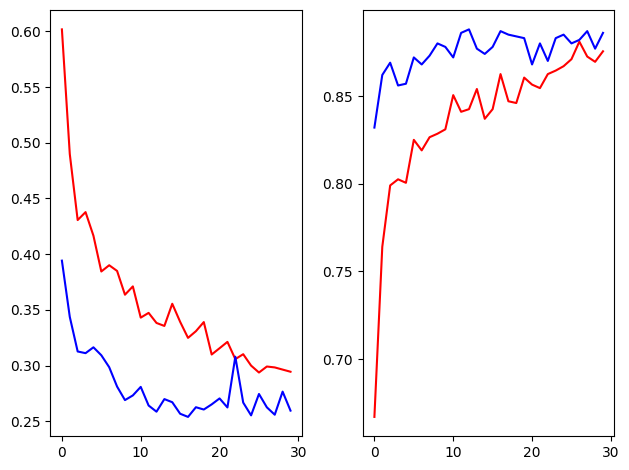

In [4]:
# 결과 그래프를 그려보아요!
import matplotlib.pyplot as plt
fig = plt.figure()

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.plot(history.history['loss'], color='r')
ax1.plot(history.history['val_loss'], color='b')

ax2.plot(history.history['accuracy'], color='r')
ax2.plot(history.history['val_accuracy'], color='b')

plt.tight_layout()
plt.show()